In [1]:
# This line will add a button to toggle visibility of code blocks,
# for use with the HTML export version
from IPython.core.display import HTML
HTML('''<button style="margin:0 auto; display: block;" onclick="jQuery('.code_cell .input_area').toggle();
    jQuery('.prompt').toggle();">Toggle code</button>''')

<img src="./Images/UoE_Horizontal_Logo_282_v1_160215.png" alt="drawing" width="600"/>

# Week 8 - Support Vector Machines
__Dr. David Elliott__

4. [Support Vector Classifier (SVC)](#svc)

5. [Support Vector Machine (SVM)](#svm)

__Common Notation__

- $\mathbf{X}$ is a matrix containing all the feature values of all the observations
- $n$ is the number of observations in the dataset
- $\mathbf{x}_i$ is a vector of all the feature values (except the label) of the $i$th instance in the dataset.
- $y_i$ is the label (desired model output) of the $i$th instance in the dataset.
- $p$ is the number of features in the dataset
- $\mathbf{x}_j$ is a vector of all the observations values of the $j$th feature in the dataset.

__Notes__

We can't always perfectly separate the data with a $p − 1$ dimensional hyperplane. To overcome this problem we could either:
- Tweak the constraints on the hyperplane to allow some points to be misclassified (_soft margin_),
- Transform the data to be separable by a hyperplane in another space (_kernel method_).

In [2]:
%matplotlib inline

import os # locating directories

import numpy as np   # Arrays
import pandas as pd  # DataFrames

# Plotting
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['animation.embed_limit'] = 30000000.0
import seaborn as sns; sns.set()

from sklearn.datasets import load_iris           # for the Iris data
from IPython.display import Image                # displaying .png images
from sklearn.svm import SVC, LinearSVC           # SVM
from mpl_toolkits.mplot3d import Axes3D          # 3d plots
from sklearn.preprocessing import StandardScaler # scaling features
from sklearn.preprocessing import LabelEncoder   # binary encoding
from sklearn.pipeline import Pipeline            # combining classifier steps
from sklearn.preprocessing import PolynomialFeatures # make PolynomialFeatures
from sklearn.datasets import make_classification, make_moons  # make example data

import itertools
from time import time
import joblib # saving models
import warnings # prevent warnings

# colours for print()
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
image_dir = os.path.join(os.getcwd(),"Images")
# Initial fig number
fig_num=15

plt.rcParams['figure.dpi'] = 120
# golden ratio for figures ()
gr = 1.618

height_pix = 500
width_pix = height_pix*gr

height_inch = 4
width_inch = height_inch*gr

# if trying to make PDF
PDF=True

In [3]:
iris = load_iris(as_frame=True)  # data stored in a `sklearn.utils.Bunch`
iris_df = iris['data']           # get features DataFrame
target = iris['target']          # get target Series
# get the labels of flowers capitalised for visualisation
target_names = list(map(lambda s: s.capitalize(), iris['target_names']))

# create a dictionary with the original labels decoded (inverse of LabelEncoder)
decode_label = dict(zip(range(3), target_names))

# make a label encoder to use later if needed
le = LabelEncoder().fit(target_names)
# add the target labels to df for visualisation purposes
iris_vis = pd.concat([iris_df, target],axis=1)
# turn the ints to labels
iris_vis["target"] = iris_vis["target"].replace(decode_label)
# Capitalize column names for plotting
iris_vis.columns = [x.capitalize() for x in list(iris_vis.columns)]
# reduce the data for example
X_AX_LABEL = "Petal length (cm)"
Y_AX_LABEL = "Petal width (cm)"
REMOVE = "Virginica"

iris_reduced = iris_vis[[X_AX_LABEL, Y_AX_LABEL, "Target"]]
iris_reduced = iris_reduced[iris_reduced.Target != REMOVE]

In [4]:
# Centered figures in the notebook and presentation
# ...was a real pain to find this:
# https://gist.githubusercontent.com/maxalbert/800b9f06c7b2dd365ea5

import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import urllib
import base64
from io import BytesIO, StringIO

def fig2str(fig, format='svg'):
    """
    Return a string containing the raw data of the matplotlib figure in the given format.

    """
    assert isinstance(fig, matplotlib.figure.Figure)
    imgdata = BytesIO()
    fig.savefig(imgdata, format=format, bbox_inches='tight')
    imgdata.seek(0)  # rewind the data
    output = imgdata.getvalue()
    if format == 'svg':
        return output
    else:
        return urllib.parse.quote(base64.b64encode(output))

class MatplotlibFigure(object):
    """
    Thin wrapper around a matplotlib figure which provides a custom
    HTML representation that allows tweaking the appearance

    """
    def __init__(self, fig, centered=False):
        assert isinstance(fig, matplotlib.figure.Figure)
        self.centered = centered

    def _repr_html_(self):
        img_str_png = fig2str(fig, format='png')
        uri = 'data:image/png;base64,' + img_str_png
        html_repr = "<img src='{}'>".format(uri)
        if self.centered:
            html_repr = "<center>" + html_repr + "</center>"
        return html_repr

# 1.4. Support Vector Classifier (SVC) <a id='svc'></a>

SVC's are a generalisation and extension of the maximal margin classifier so it can be applied to a broader range of cases$^1$.

In practice they are more robust to individual observations and better classify most training observations than the Maximal Margin Classifier. This is because they take the approach it is better to missclassify some training examples in order to do a better job classifying the rest.

This is called a *soft margin* as it allows some violations by the training data by a small subset of training observation, not only on the wrong side of the margin, but wrong side of the hyperplane.

__Notes__
- _"Developed in the computer science community in the 1990s"_$^2$

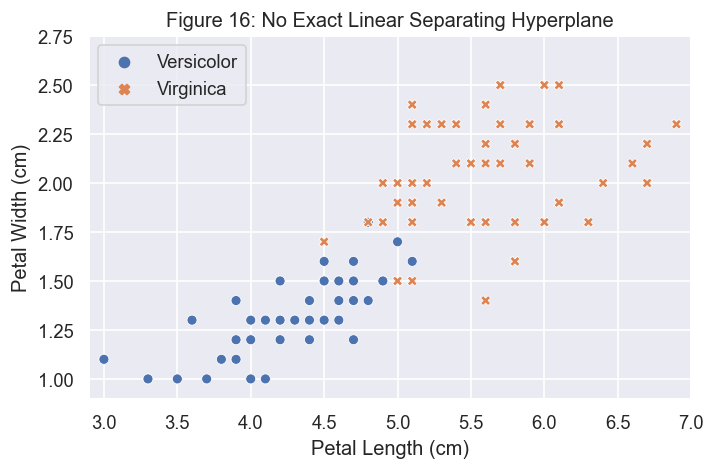

In [5]:
def svc_decision_boundary(clf, xmin=0, xmax=5.5, highlight=True, axes_limit = [0, 5.5, 0, 2]):
    w = clf.coef_[0]
    b = clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = clf.support_vectors_
    if highlight:
        g = sns.scatterplot(x = svs[:, 0], y = svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "g-", linewidth=2)
    plt.plot(x0, gutter_up, "r--", linewidth=2)
    plt.plot(x0, gutter_down, "r--", linewidth=2)
    
    plt.axis(axes_limit)


def soft_margin(title, hyperplane=False):
    virgin_versi = iris_vis[["Petal length (cm)", "Petal width (cm)", "Target"]]
    virgin_versi = virgin_versi[virgin_versi.Target != "Setosa"]

    X = virgin_versi[["Petal length (cm)", "Petal width (cm)"]].values
    y = virgin_versi[["Target"]].replace({'Versicolor':0, 'Virginica':1}).values.ravel()
    
    if hyperplane:
        svm_clf = SVC(kernel="linear", C=100)
        svm_clf.fit(X, y)

        svc_decision_boundary(svm_clf, 2.9, 7)
    labels = virgin_versi[["Target"]].values.ravel()
    sns.scatterplot(x = X[:,0], y = X[:,1], hue=labels, style = labels)
    plt.axis([2.9, 7, 0.9, 2.75])
    plt.title(title)
    plt.xlabel("Petal Length (cm)")
    plt.ylabel("Petal Width (cm)")
    
fig_num+=1
fig = plt.figure(figsize=(width_inch, height_inch))
soft_margin("Figure %d: No Exact Linear Separating Hyperplane"%fig_num)
if PDF:
    plt.show()
    plt.close()
else:
    plt.close()
    display(MatplotlibFigure(fig, centered=True))

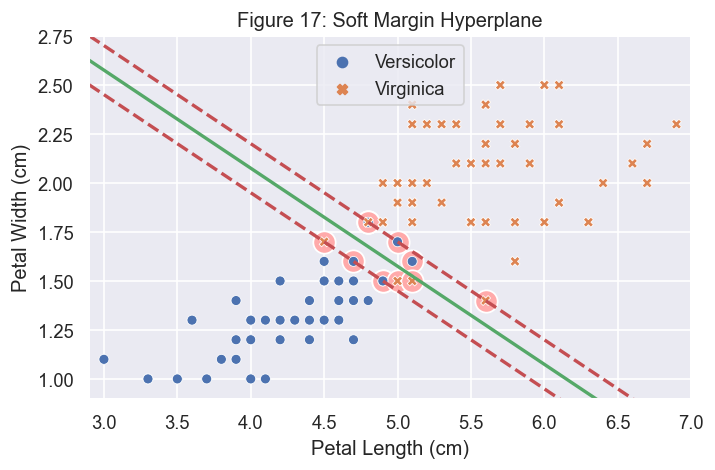

In [6]:
fig_num+=1
fig = plt.figure(figsize=(width_inch, height_inch))
soft_margin("Figure %d: Soft Margin Hyperplane"%fig_num, hyperplane=True)
plt.savefig(os.path.join(image_dir,"Soft_Margin_Hyperplane.png"))
if PDF:
    plt.show()
    plt.close()
else:
    plt.close()
    display(MatplotlibFigure(fig, centered=True))

We want to relax the following constraints when necessary:

$$
\mathbf{w}^{\mathrm T}\mathbf{x}_i + b \geq 1 \text{ for } y_i = 1, \\
\mathbf{w}^{\mathrm T}\mathbf{x}_i + b \leq -1 \text{ for } y_i = -1
$$

This can be done by introducing positive slack variables $\xi_i, i = 1, \ldots, n$ in the constraints$^{5,6,10}$:

$$
\mathbf{w}^{\mathrm T}\mathbf{x}_i + b \geq 1 - \xi_i \quad \text{if} \quad y_i = 1, \\
\mathbf{w}^{\mathrm T}\mathbf{x}_i + b \leq -1 + \xi_i \quad \text{if} \quad y_i = -1, \\
\xi_i \geq 0 \quad \forall_i.
$$

__Notes__

- Slack variable $\xi_1,..., \xi_n$ allow individual observations to be on the wrong side of the margin or hyperplane.
- $\sum_i\xi_i$ is an upper bound on the number of training errors.
- $\xi_i$ tells us where the $i$th observation is located relative to the hyperplane; $\xi_i = 0$ being on the correct side of the margin, $\xi_i > 0$ being on the wrong side of the margin, and $\xi_i > 1$ on the wrong side of the hyperplane.
- $\xi_1 = ... = \xi_n = 0$ is the maximal margin hyperplane optimisation.
- Test observations are classified as before, $f(x^*) = \beta_0 + \beta_1x^*_1 + ... + \beta_px^*_p$.

## Tuning Parameter (C)

To ensure there is a penelty, $C$, for relaxing the constraint, we can change our objective function to be minimised from $\frac{1}{2}||\mathbf{w}||^2$ to,

In [30]:
from IPython.display import Math

display(Math(
r"""
\begin{align}
{\text{minimise}  \atop \mathbf{w}, b, \xi } & \quad \frac{1}{2}||\mathbf{w}||^2+C\sum\limits_{i=1}^n\xi_i, \\ 
\text{subject to}                            & \quad y_i(\mathbf{w}^{\mathrm T}\mathbf{x}_i+b) \geq 1-\xi_i, \quad \xi_i \geq 0, \quad \forall_i.
\end{align}
"""))

<IPython.core.display.Math object>

$C$ is a tuning parameter that controls the bias-variance trade-off$^1$. 

The strength of the regularization is inversely proportional to $C$, meaning a large $C$ has a larger error penalty.

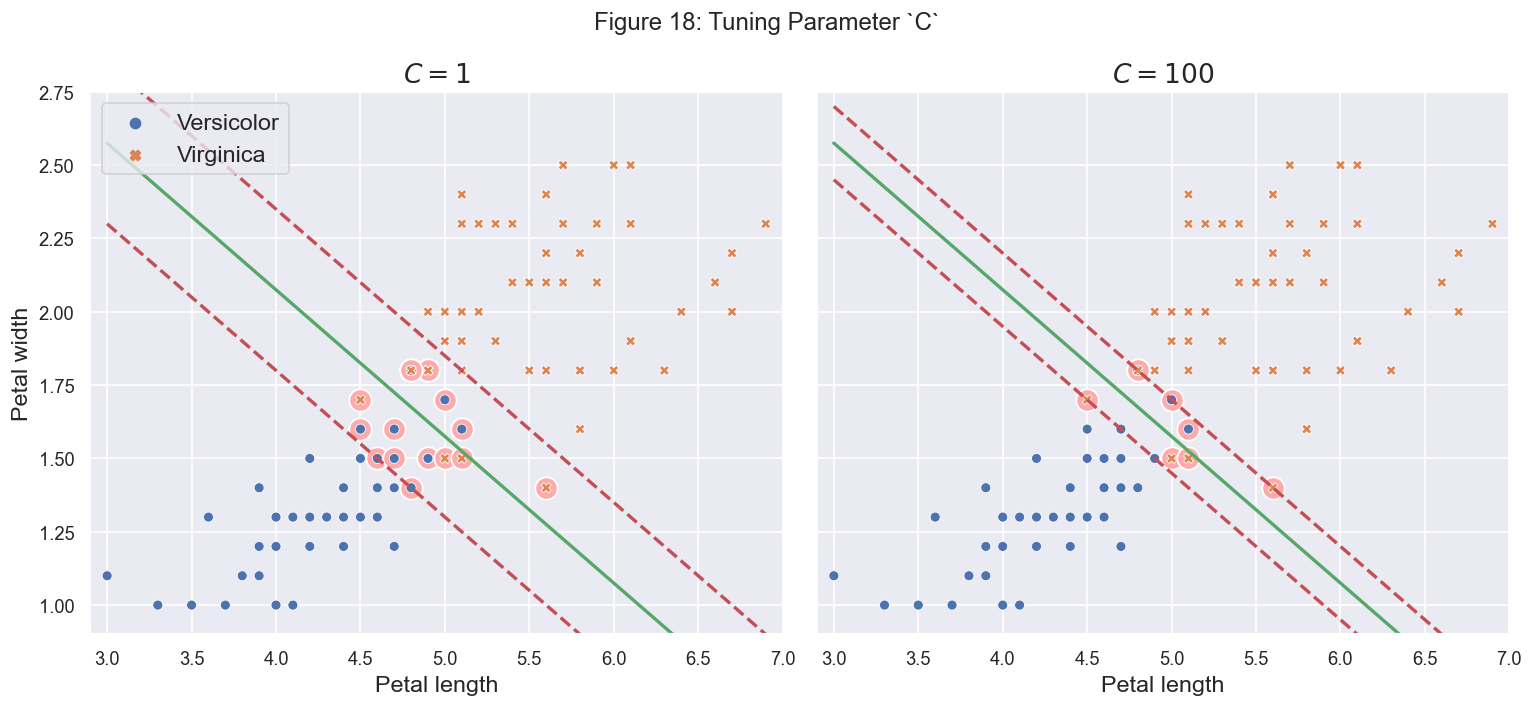

In [8]:
def soft_margin(c_list, main_title):
    virgin_versi = iris_vis[["Petal length (cm)", "Petal width (cm)", "Target"]]
    virgin_versi = virgin_versi[virgin_versi.Target != "Setosa"]

    X = virgin_versi[["Petal length (cm)", "Petal width (cm)"]].values
    y = virgin_versi[["Target"]].replace({'Versicolor':0, 'Virginica':1}).values.ravel()

    scaler = StandardScaler()
    svm_clf1 = LinearSVC(C=c_list[0], loss="hinge", random_state=42)
    svm_clf2 = LinearSVC(C=c_list[1], loss="hinge", random_state=42)

    scaled_svm_clf1 = Pipeline([
            ("scaler", scaler),
            ("linear_svc", svm_clf1),
        ])
    scaled_svm_clf2 = Pipeline([
            ("scaler", scaler),
            ("linear_svc", svm_clf2),
        ])

    scaled_svm_clf1.fit(X, y)
    scaled_svm_clf2.fit(X, y)

    # Convert to unscaled parameters
    b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
    b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
    w1 = svm_clf1.coef_[0] / scaler.scale_
    w2 = svm_clf2.coef_[0] / scaler.scale_
    svm_clf1.intercept_ = np.array([b1])
    svm_clf2.intercept_ = np.array([b2])
    svm_clf1.coef_ = np.array([w1])
    svm_clf2.coef_ = np.array([w2])

    # Find support vectors (LinearSVC does not do this automatically)
    t = y * 2 - 1
    support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
    support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
    svm_clf1.support_vectors_ = X[support_vectors_idx1]
    svm_clf2.support_vectors_ = X[support_vectors_idx2]

    fig, axes = plt.subplots(ncols=2, figsize=(width_inch*2, height_inch*1.5), sharey=True)

    plt.sca(axes[0])
    svc_decision_boundary(svm_clf1, 3, 7)
    legend_labels = virgin_versi[["Target"]].values.ravel()
    sns.scatterplot(x = X[:,0], y = X[:,1], hue=legend_labels, style = legend_labels)
    plt.xlabel("Petal length", fontsize=14)
    plt.ylabel("Petal width", fontsize=14)
    plt.legend(loc="upper left", fontsize=14)
    plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
    plt.axis([2.9, 7, 0.9, 2.75])

    plt.sca(axes[1])
    svc_decision_boundary(svm_clf2, 3, 7)
    g = sns.scatterplot(x = X[:,0], y = X[:,1], hue=legend_labels, style = legend_labels, legend=False)
    plt.xlabel("Petal length", fontsize=14)
    plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
    plt.axis([2.9, 7, 0.9, 2.75])
    plt.suptitle(main_title)
    plt.tight_layout()
    
    return fig

fig_num+=1
fig = soft_margin([1,100], "Figure %d: Tuning Parameter `C`"%fig_num)
if PDF:
    plt.show()
    plt.close()
else:
    plt.close()
    display(MatplotlibFigure(fig, centered=True))

__Extra__

Neither the $\xi_i$ or their Lagrange multipliers appear in the Wolfe dual problem. This means we now have$^6$:

$\text{max} L_D \equiv \sum_i^n\alpha_i - \frac{1}{2}\sum^n_{i,k}\alpha_i\alpha_ky_iy_k\mathbf{x}_i\cdot \mathbf{x}_k \quad \text{s.t.} \quad 0 \leq \alpha_i \leq C, \quad \sum_i\alpha_iy_i = 0$.

This also has the same solution as before:

$\mathbf{\hat w} = \sum\limits^{N_S}_{i=1}\alpha_iy_i\mathbf{x}_i$.

Also, sometimes $C$ is defined as $C = \frac{1}{\nu N}$, where $0 < \nu \leq 1$ controls the fraction of misclasified points during the training phase$^7$. 

__Notes__

- Alike to maximal margin classifiers, SVC's only rely on a few observations, those on the margin or those that violate the margin (*Support Vectors*).
    - If they are on the correct side of the margin they dont change the classifier. 
    - This does mean that they are robust to observations far away from the hyperplane.
- When $C$ is large we have narrow margins rarely violated, but highly fit to the training data (low bias-high variance). 
- Coversely, when smaller it is less strict about missclassification errors, meaning the margin is wider (high bias-low variance).
- Like most hyper-parameters, it is often chosen using cross-validation.

# 1.5. Support Vector Machine (SVM) <a id='svm'></a>
Aims to address the situation where the boundary between two classes is not linear.

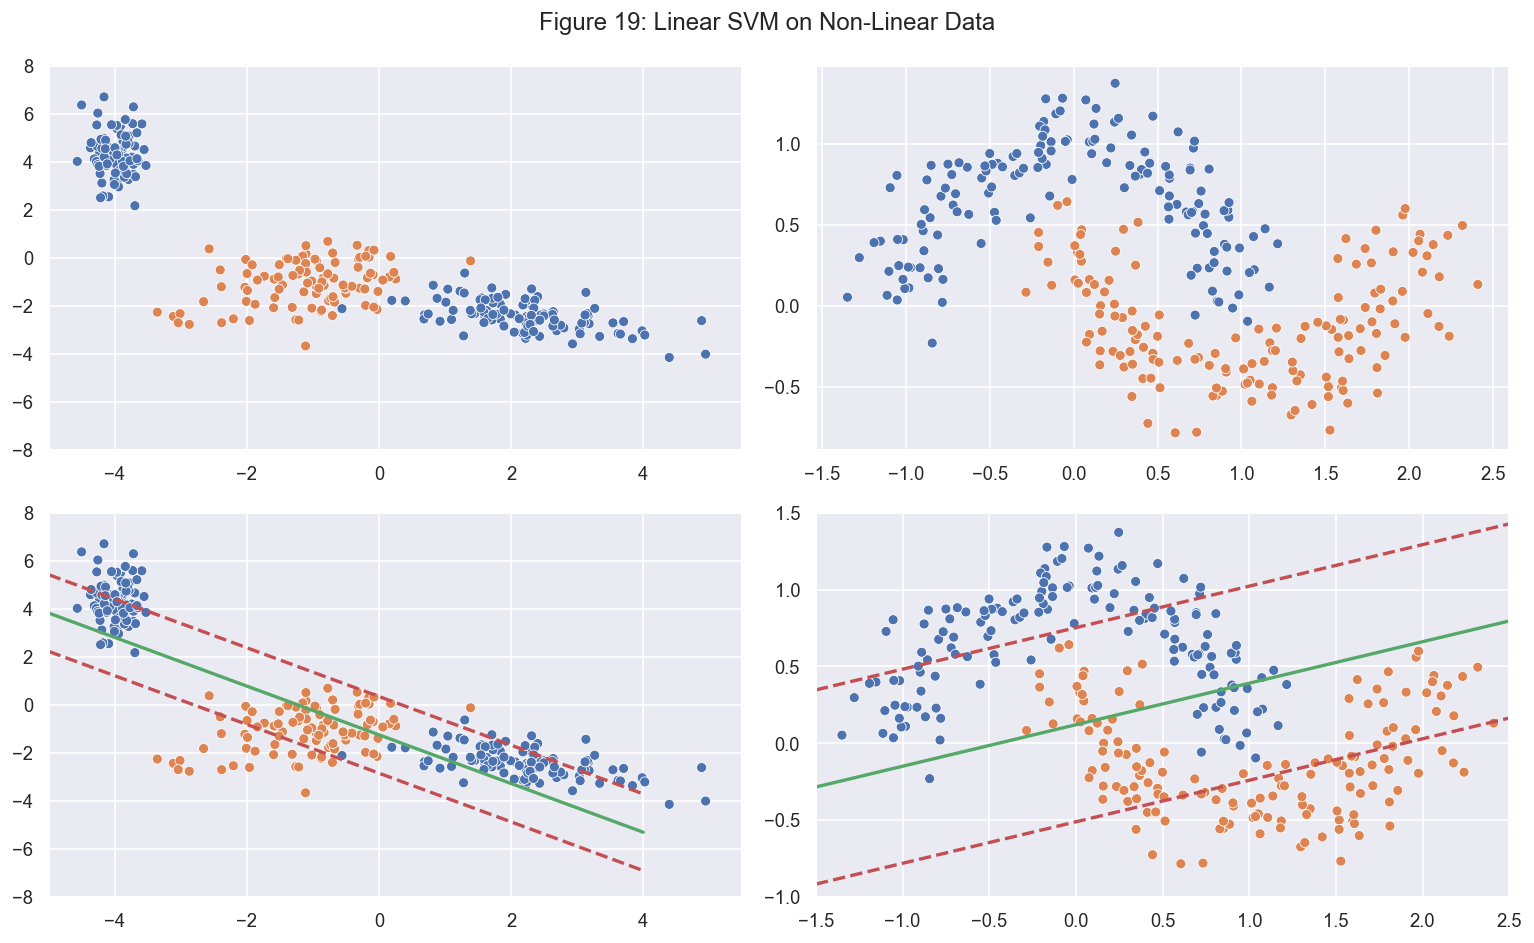

In [9]:
from sklearn.preprocessing import PolynomialFeatures
import warnings

nl1, y1 = make_classification(n_samples=300, n_features=2,
                              n_redundant=0, n_informative= 2, 
                              n_classes=3, n_clusters_per_class=1, 
                              random_state=14, class_sep=30, 
                              hypercube=False)
y1 = np.where(y1==1,0,y1)
y1 = np.where(y1==2,1,y1)

nl2, y2 = make_moons(n_samples=300, noise=0.15, random_state=42)

def non_linear_examples(main_title):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(width_inch*2, height_inch*2))
    axes = axes.flatten()
    plt.sca(axes[0])
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)
    plt.axis([-5, 5.5, -8, 8])

    plt.sca(axes[1])
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)
    
    svm_clf1 = LinearSVC(random_state=42).fit(nl1, y1)
    svm_clf2 = LinearSVC(random_state=42).fit(nl2, y2)

    # Convert to unscaled parameters
    b1 = svm_clf1.intercept_[0]
    b2 = svm_clf2.intercept_[0]
    w1 = svm_clf1.coef_[0]
    w2 = svm_clf2.coef_[0]

    # Find support vectors (LinearSVC does not do this automatically)
    t1 = y1 * 2 - 1
    t2 = y2 * 2 - 1
    support_vectors_idx1 = (t1 * (nl1.dot(w1) + b1) < 1).ravel()
    support_vectors_idx2 = (t2 * (nl2.dot(w2) + b2) < 1).ravel()
    svm_clf1.support_vectors_ = nl1[support_vectors_idx1]
    svm_clf2.support_vectors_ = nl2[support_vectors_idx2]

    plt.sca(axes[2])
    svc_decision_boundary(svm_clf1, -5, 4, highlight=False, axes_limit = [-5, 5.5, -8, 8])
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)

    plt.sca(axes[3])
    svc_decision_boundary(svm_clf2, -1.5, 2.5, highlight=False, axes_limit = [-1.5, 2.5, -1, 1.5])
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)
    
    plt.suptitle(main_title)
    plt.tight_layout()
    
    return fig
    
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig_num+=1
    fig = non_linear_examples("Figure %d: Linear SVM on Non-Linear Data"%fig_num)
    if PDF:
        plt.show()
        plt.close()
    else:
        plt.close()
        display(MatplotlibFigure(fig, centered=True))

## Feature Engineering

We could consider enlarging the feature space to make the dataset linearly separable.

__Example:__
We can see below that our $\mathbf{x}_1$ is not linearly separable but it is when we add in our second feature $\mathbf{x}_2 = (\mathbf{x}_1)^2$

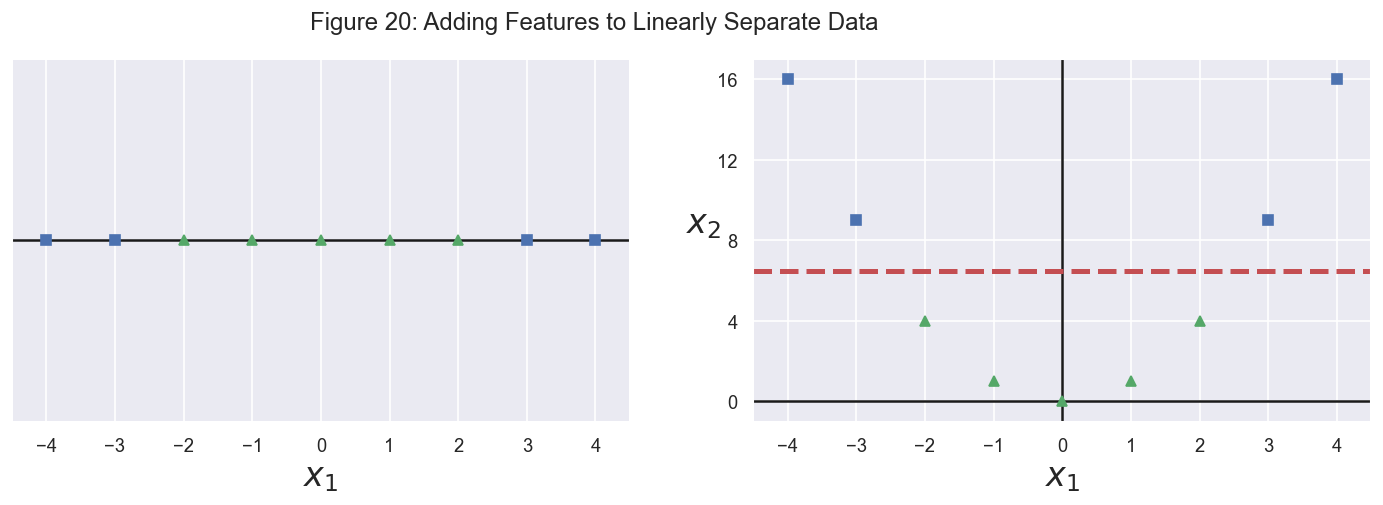

In [10]:
# https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def poly_info(main_title):
    X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
    X2D = np.c_[X1D, X1D**2]
    y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    fig = plt.figure(figsize=(width_inch*2, height_inch))

    plt.subplot(121)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
    plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
    plt.gca().get_yaxis().set_ticks([])
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.axis([-4.5, 4.5, -0.2, 0.2])

    plt.subplot(122)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
    plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
    plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
    plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
    plt.axis([-4.5, 4.5, -1, 17])

    plt.subplots_adjust(right=1)

    plt.suptitle(main_title)
    return fig
    
fig_num+=1
fig = poly_info("Figure %d: Adding Features to Linearly Separate Data"%fig_num)
if PDF:
    plt.show()
    plt.close()
else:
    plt.close()
    display(MatplotlibFigure(fig, centered=True))

Using quadratic, cubic or higher-order polynomial functions we can project our data onto a higher-dimensional space via a mapping function $\phi$ where they are linearly separable (using a linear SVM model in this new feature space). 

__Example__

$\phi(\mathbf{x}_1, \mathbf{x}_2) = (\mathbf{z}_1,\mathbf{z}_2,\mathbf{z}_3) = (\mathbf{x}_1,\mathbf{x}_2,\mathbf{x}^2_1+\mathbf{x}^2_2)$

Figure 21: 2D Dataset into Separable 3D Feature Space


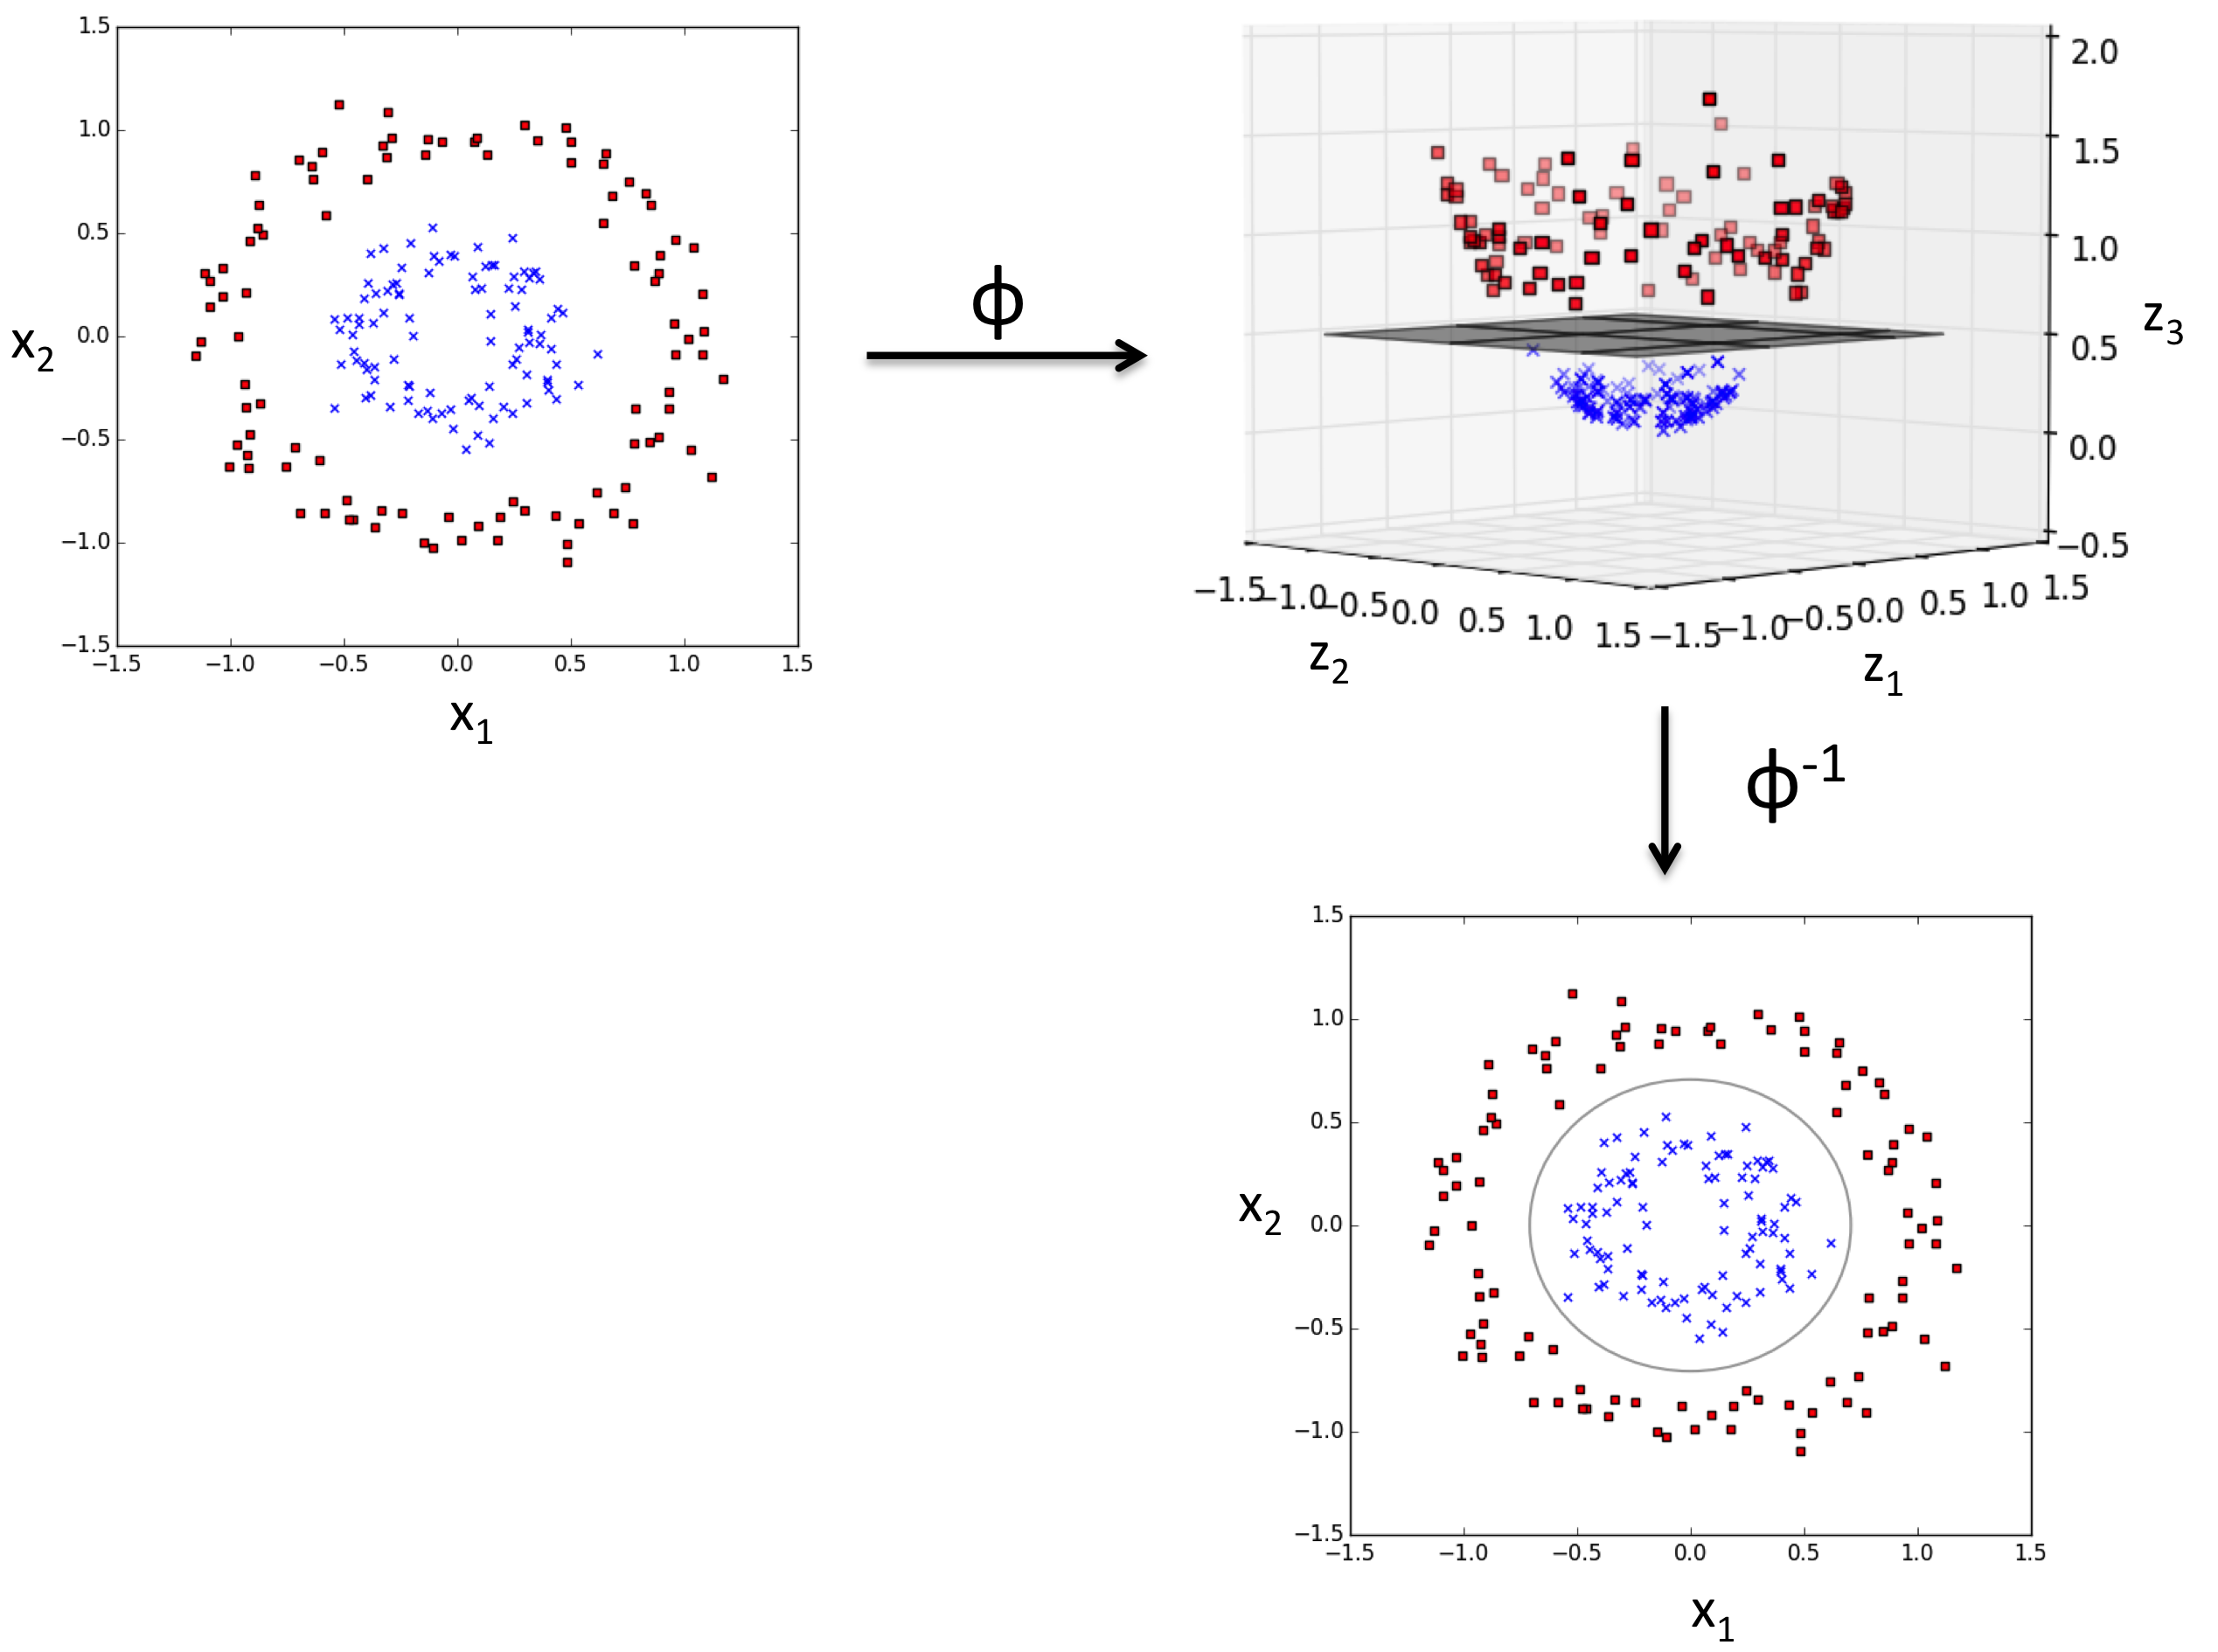

In [11]:
# TODO - if time code something like this up
fig_num+=1
print(color.BOLD+color.UNDERLINE+"Figure %d: 2D Dataset into Separable 3D Feature Space"%fig_num+color.END)
# Image from https://github.com/rasbt/python-machine-learning-book-3rd-edition/blob/master/ch03/ch03.ipynb
Image(filename='Images/03_13.png', width=width_pix)

### Gaussian Radial Basis Function$^2$

We could instead use a _"similarity function"_, such as a Gaussian Radial Basis Function (RBF),

$\phi_\gamma(\mathbf{x},\ell) = \exp(-\gamma||\mathbf{x}-\ell||^2)$.

This is a bell-shaped function which measures how much an instance resembles a _landmark_, with the function varying from 0 (far away) to 1 (at the landmark).

__Example:__ Below we set our landmarks to $x_1 = -2$ and $x_1 = 1$. 

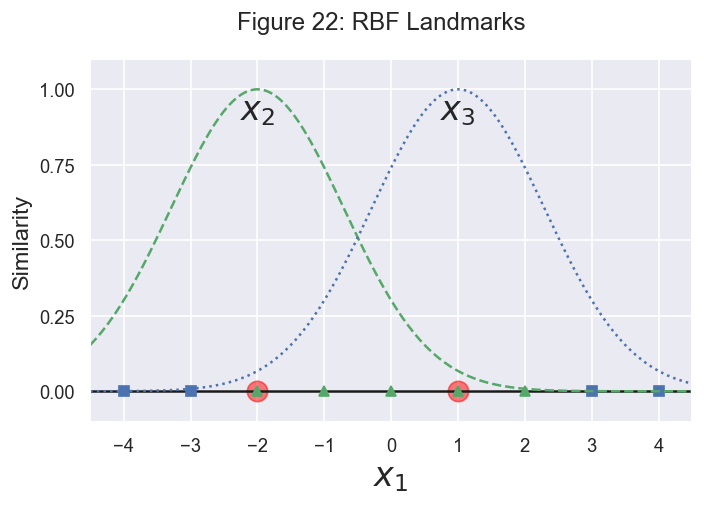

In [12]:
# copied from https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def gaussian_rbf(x, landmark, gamma):
        return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

def rbk_info(main_title):

    gamma = 0.3
    X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
    X2D = np.c_[X1D, X1D**2]
    y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
    x2s = gaussian_rbf(x1s, -2, gamma)
    x3s = gaussian_rbf(x1s, 1, gamma)

    XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
    yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    fig = plt.figure(figsize=(width_inch, height_inch))

    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
    plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
    plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
    plt.plot(x1s, x2s, "g--")
    plt.plot(x1s, x3s, "b:")
    plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"Similarity", fontsize=14)
    plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
    plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
    plt.axis([-4.5, 4.5, -0.1, 1.1])
    
    plt.suptitle(main_title)
    
    return fig
    
fig_num+=1
fig = rbk_info("Figure %d: RBF Landmarks"%fig_num)
if PDF:
    plt.show()
    plt.close()
else:
    plt.close()
    display(MatplotlibFigure(fig, centered=True))

Using the example of $x_1=-1$ we can see it is a distance of 1 from the first landmark and 2 from the second.

If we set $\gamma = 0.3$ then our new features are:

$x_2 = \exp(-0.3 \times 1^2) \approx 0.74$

$x_3 = \exp(-0.3 \times 2^2) \approx 0.30$

In order to find the landmarks the simplist approach is just to create a landmark at each instance in the dataset.

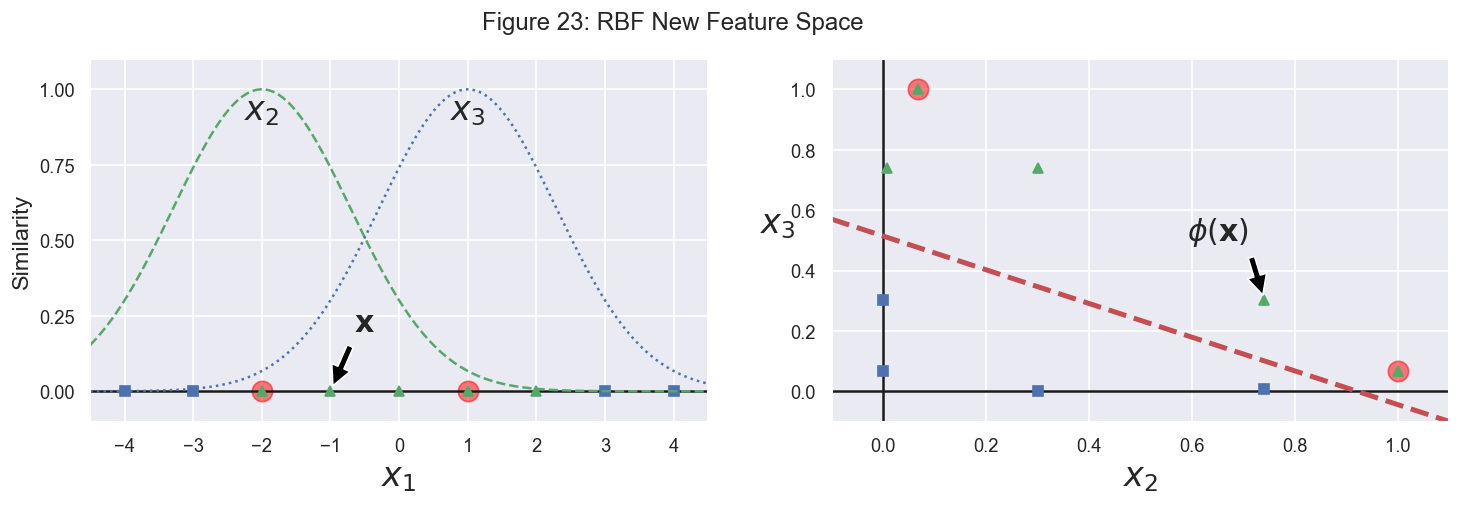

In [13]:
import math

# copied from https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
def gaussian_rbf(x, landmark, gamma):
        return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

def rbk_info(main_title):

    gamma = 0.3
    X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
    X2D = np.c_[X1D, X1D**2]
    y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
    x2s = gaussian_rbf(x1s, -2, gamma)
    x3s = gaussian_rbf(x1s, 1, gamma)

    XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
    yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

    fig = plt.figure(figsize=(width_inch*2, height_inch))

    plt.subplot(121)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
    plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
    plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
    plt.plot(x1s, x2s, "g--")
    plt.plot(x1s, x3s, "b:")
    plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"Similarity", fontsize=14)
    plt.annotate(r'$\mathbf{x}$',
                 xy=(X1D[3, 0], 0),
                 xytext=(-0.5, 0.20),
                 ha="center",
                 arrowprops=dict(facecolor='black', shrink=0.1),
                 fontsize=18,
                )
    plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
    plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
    plt.axis([-4.5, 4.5, -0.1, 1.1])

    plt.subplot(122)
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
    plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
    plt.scatter(x=[math.exp(-0.3*(0.**2.)), math.exp(-0.3*(3.**2.))], y=[math.exp(-0.3*(3.**2.)), math.exp(-0.3*(0.**2.))], s=150, alpha=0.5, c="red")
    plt.xlabel(r"$x_2$", fontsize=20)
    plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
    plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
                 xy=(XK[3, 0], XK[3, 1]),
                 xytext=(0.65, 0.50),
                 ha="center",
                 arrowprops=dict(facecolor='black', shrink=0.1),
                 fontsize=18,
                )
    plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
    plt.axis([-0.1, 1.1, -0.1, 1.1])

    plt.subplots_adjust(right=1)
    
    plt.suptitle(main_title)

    return fig

fig_num+=1
fig = rbk_info("Figure %d: RBF New Feature Space"%fig_num)
if PDF:
    plt.show()
    plt.close()
else:
    plt.close()
    display(MatplotlibFigure(fig, centered=True))

## Kernels

However, by using feature engineering to enlarge our feature space, the larger the number of features, the higher computational burden. 

Instead it is common to enlarge the feature space using an extension of a SVC termed a Support Vector Machine, which uses _kernels_.

The Kernel trick can relies on the fact we can define our SVM in the form of inner products.

$$
L_D(\alpha_i) = \sum_i^n\alpha_i - \frac{1}{2}\sum_{i,k}^n\alpha_i\alpha_ky_iy_k\mathbf{x}_i^{\mathrm T}\mathbf{x}_k \qquad \text{s.t.} \quad \forall_i \alpha_i \geq 0, \ \sum_i^n\alpha_iy_i = 0.
$$

Imagine we had a mapping $\phi$ which maps the data to some high dimensional Euclidean space 

$$
\phi: \mathbb{R}^d \mapsto H,
$$

then, we could do dot products between vectors after the mapping in $H$:

$$
L_D(\alpha_i) = \sum_i^n\alpha_i - \frac{1}{2}\sum_{i,k}^n\alpha_i\alpha_ky_iy_k\phi(\mathbf{x}_i^{\mathrm T})\phi(\mathbf{x}_k)
$$

Instead we could use a kernel function,

$$
K(\mathbf{x}_i,\mathbf{x}_k) = \phi(\mathbf{x}_i^{\mathrm T})\Phi(\mathbf{x}_k).
$$

__Notes__

- Roughly speaking, a kernel can be interpreted as a similarity function betwen pairs of samples$^4$.
- $\mathbf{a} \in \mathbb{R}^k$ just means it is a vector of length $k$. 
- $\mathbf{A} \in \mathbb{R}^{r\times s}$ just means it is an $r \times s$ matrix.
- $\mathbf{w}$ lives in $H$ ("high dimensional")
- $H$ is often refered to as a Hilbert space.
- _"it is clear that the above implicit mapping trick will work for any algorithm in which the data only appear as dot products (for example, the nearest neighbor algorithm). This fact has been used to derive a nonlinear version of principal component analysis by (Scholkopf, Smola and Muller, 1998b); it seems likely that this trick will continue to find uses elsewhere."_$^6$

__Second-Degree Polynomial Example$^2$__

Suppose we wanted to apply a second-degree polynomial transformation to two 2D vectors, $\mathbf{a}$ and $\mathbf{b}$, and then compute the dot product. We could do this by:

$$
\phi(\mathbf{a})^{\mathrm T}\phi(\mathbf{b}) = \begin{pmatrix} {a_1}^2 \\ \sqrt{2a_1a_2} \\ {a_2}^2 \end{pmatrix}^{\mathrm T} \begin{pmatrix} {b_1}^2 \\ \sqrt{2b_1b_2} \\ {b_2}^2\end{pmatrix} = {a_1}^2{b_1}^2+2a_1b_1a_2b_2+{a_2}^2{b_2}^2.
$$

Instead we could use the kernel approach:

$$
K(\mathbf{a}, \mathbf{b}) = (\mathbf{a}^{\mathrm T}\mathbf{b})^2 = \begin{pmatrix} \begin{pmatrix} a_1 \\ a_2 \end{pmatrix}^{\mathrm T}\begin{pmatrix} b_1 \\ b_2 \end{pmatrix}\end{pmatrix}^2 = (a_1b_1+a_2b_2)^2 = {a_1}^2{b_1}^2+2a_1b_1a_2b_2+{a_2}^2{b_2}^2.
$$

This is useful as it means we didnt have to map our data using $\phi$ first. This saves us time!

__Notes__

- A second-degree polynomial for a training set with two features, $\mathbf{x} \in \mathbb{R}^2$, would be:

$$\Phi(\mathbf{x}) = \Phi((\mathbf{x}_1, \mathbf{x}_2)) = ({\mathbf{x}_1}^2, \sqrt{2\mathbf{x}_1\mathbf{x}_2}, {\mathbf{x}_2}^2)$$

In [14]:
# TODO: Time allowing, look at if this increases as polynomial degree increases...
# it doesnt always work - guess it depends how my computer is feeling :P

# https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_feat = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel='poly', degree=2, C=10, random_state=42))
    ])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(color.BOLD+color.UNDERLINE+"Polynomial Feature Engineering (degree=2)"+color.END)
    %timeit polynomial_feat.fit(nl2, y2)
    print(color.BOLD+color.UNDERLINE+"Polynomial Kernel (degree=2)"+color.END)
    %timeit polynomial_svm.fit(nl2, y2)

Polynomial Feature Engineering (degree=2)
2.11 ms ± 42.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Polynomial Kernel (degree=2)
3.04 ms ± 57.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


We still have all the same considerations, but replacing $\mathbf{x}_i^{\mathrm T} \mathbf{x}_k$ with $K(\mathbf{x}_i, \mathbf{x}_k)$ allows us to produce a SVM in infinite dimensional space.

$$
\sum_i^n\alpha_i - \frac{1}{2}\sum_i^n\sum_k^n\alpha_i\alpha_ky_iy_kK(\mathbf{x}_i, \mathbf{x}_k) \qquad \text{s.t.} \quad \forall_i \alpha_i \geq 0, \ \sum_i^n\alpha_iy_i = 0.
$$

In the test phase, we can use the support vectors$^6$:

In [15]:
from IPython.display import Math

display(Math(
r"""
\begin{align}
f(\mathbf{x}^*) &= \sum_{i \in s}\hat\alpha_iy_i\phi(\mathbf{x}_i)\cdot \phi(\mathbf{x}^*) + \hat b \\
                &= \sum_{i \in s}\hat\alpha_iy_iK(\mathbf{x}_i,\mathbf{x}^*) +\hat b,
\end{align}
"""))

<IPython.core.display.Math object>

avoiding computing $\Phi(\mathbf{x}^*)$.

__Note__
- Put another way, in the test phase$^6$, we can use the support vectors, $\mathbf{s}_i$:

In [16]:
display(Math(
r"""
\begin{align}
f(\mathbf{x}^*) &= \sum_{i = 1}^{n_s}\hat\alpha_iy_i\Phi(\mathbf{s}_i)\cdot \Phi(\mathbf{x}^*) + \hat b \\
                &= \sum_{i = 1}^{n_s}\hat\alpha_iy_iK(\mathbf{s}_i,\mathbf{x}^*) +\hat b.
\end{align}
"""))

<IPython.core.display.Math object>

## Polynomial kernels

The polynomial kernel of degree $d$ (a positive integer) can be defined as:

$$K(\mathbf{x}_i,\mathbf{x}_k) = \left(\gamma \left<\mathbf{x}_i, \mathbf{x}_k\right> + r \right)^d$$

### Hyperparameters
- $\gamma$ (`gamma`) broadly defines the width or slope of kernel function<sup>13</sup>.
- $r$ (`coef0`) roughly controls how much the model is influenced by high-degree polynomials<sup>2</sup>.
- $d$ (`degree`) is the degree of the polynomial.

__Notes__
- You will sometimes see a kernel defined in a general sense using $K(\mathbf{x},\mathbf{x}^\prime)$, where $\mathbf{x}^\prime$ means another point in the dataset.
- $\left<x_i, x_j\right> = x_i \cdot x_j = \mathbf{x}_i^{\mathrm T} \mathbf{x}_k$.
- $\gamma$ is often 1.
- _"The ‘curve’ of the decision boundary becomes very low when gamma value is low making the decision region very broad. The ‘curve’ of the decision boundary becomes high when gamma is high, which creates islands of decision-boundaries around data points."_<sup>13</sup>
- $d$ is a positive integer.
- If you start to overfit you should reduce the polynomial degree and underfitting try increasing it.

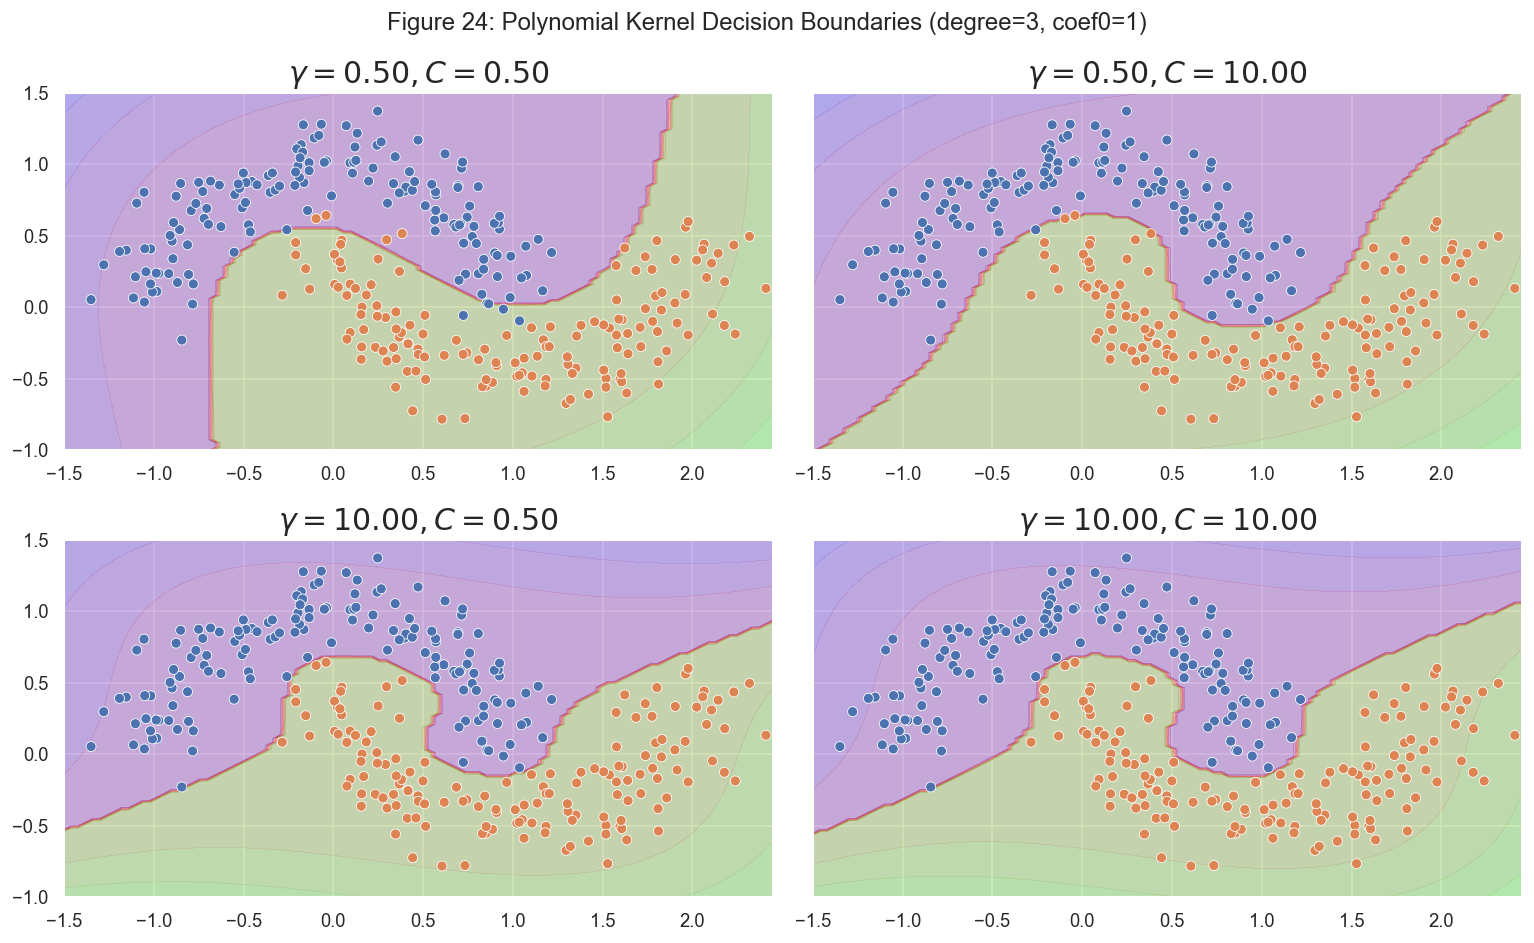

In [17]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", gamma=1, degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(nl2, y2)

poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", gamma=10, degree=3, coef0=1, C=5))
    ])
poly100_kernel_svm_clf.fit(nl2, y2)

fig, axes = plt.subplots(ncols=2, nrows =2, figsize=(width_inch*2, height_inch*2), sharey=True)

axes = axes.flatten()

gamma_list=[0.5,10]
C_list=[0.5,10]

i=0
for gamma in gamma_list:
    for C in C_list:
        poly_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="poly", 
                            gamma=gamma,
                            C=C,
                            degree=3, coef0=1))
        ])
        poly_kernel_svm_clf.fit(nl2, y2)
        warnings.simplefilter("ignore")
        plt.sca(axes[i])
        plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)
        plt.title(r"$\gamma = %.2f, C=%.2f$"%(gamma, C), fontsize=18)
        plt.ylabel("")
        i+=1
    
fig_num+=1
plt.suptitle("Figure %d: Polynomial Kernel Decision Boundaries (degree=3, coef0=1)"%fig_num)
plt.tight_layout()

if PDF:
    plt.show()
    plt.close()
else:
    plt.close()
    display(MatplotlibFigure(fig, centered=True))

You shouldnt stick to the default settings, instead you want to search for optimal hyperparameters for the data. Good suggestions for search spaces are:

- _"The authors of libsvm (Hsu et al. 2009) recommend using cv over a 2d grid with values $C \in \{2^{-5}, 2^{-3}\,\ldots,2^{15}\}$ and $\gamma \in \{2^{-15}, 2^{-13}, \ldots,2^{3}\}$"_<sup>4</sup>.

In [18]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

def hyper_search(model, params, X, y, save_path, n_iter=60, metric="accuracy", 
                 cv = KFold(5), random_state=42, refit=True,
                 overwrite=False):
    if os.path.exists(save_path) and overwrite==False:
        #load the model
        models = joblib.load(save_path)
    else:
        # check all param inputs are lists
        if all(type(x)==list for x in params.values()):
            search_type = "Gridsearch"
            models = GridSearchCV(model, param_grid=params, scoring=metric, cv=cv, 
                                  refit=refit, return_train_score=True)
            n_iter = len(list(itertools.product(*list(iter(params.values())))))
        else:
            search_type = "Randomsearch"
            models = RandomizedSearchCV(model, param_distributions=params,
                                        n_iter=n_iter, scoring=metric, cv=cv,
                                        refit=refit, random_state=random_state,
                                        return_train_score=True)
        
        start = time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            models.fit(X, y)
        
        print(search_type + " took %.2f seconds for %d candidates" % ((time() - start), n_iter))
        joblib.dump(models, save_path)
    
    return models

In [19]:
C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2

gamma_list = []
pwr = -15
for i in range(10):
    gamma_list.append(2**pwr)
    pwr+=2
    
degree_list = list(range(1,5))

coef0_list = []
pwr = 1
for i in range(7):
    coef0_list.append(2**pwr)
    pwr+=1
    
poly_param_grid = {'svm_clf__C':C_list,
                   'svm_clf__gamma': gamma_list,
                   'svm_clf__degree': degree_list,
                   'svm_clf__coef0':coef0_list}

poly = SVC(random_state=42, kernel = 'poly', max_iter = 1e5)
poly_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", poly)])

nl2_poly_gs = hyper_search(poly_svm, poly_param_grid, nl2, y2,
                             os.path.join(os.getcwd(), "Models", "moons_poly_gs.pkl"), 
                             overwrite=False)

pd.DataFrame(nl2_poly_gs.cv_results_).sort_values("rank_test_score")[["param_svm_clf__C", 
                                                                        "param_svm_clf__gamma",
                                                                        "param_svm_clf__degree",
                                                                        "param_svm_clf__coef0",
                                                                        "mean_test_score", 
                                                                        "std_test_score"]].head()

param_svm_clf__C param_svm_clf__gamma param_svm_clf__degree  \
2829            32768                    8                     3   
957                 2                  0.5                     4   
1796              128                0.125                     4   
1149                8                    8                     3   
757               0.5                  0.5                     4   

     param_svm_clf__coef0  mean_test_score  std_test_score  
2829                    2         0.996667        0.006667  
957                     8         0.996667        0.006667  
1796                    8         0.996667        0.006667  
1149                    2         0.996667        0.006667  
757                    32         0.996667        0.006667

## Radial Basis Function kernel
The most widely used kernel is the RBF kernel (also known as a Gaussian kernel)$^{4,8}$:

$$K(\mathbf{x}_i,\mathbf{x}_k) = \exp\left(-\gamma||\mathbf{x}_i-\mathbf{x}_k||^2\right),$$

where $\gamma$ is a free parameter to be optimised and $||\mathbf{x}_i-\mathbf{x}_k||^2$ is the squared _Euclidean distance_.

$\gamma$ is often either a positive constant or  $\frac{1}{2\sigma^2}$.

When classifying a test observation $\mathbf{x}^* = (x^*_1...x^*_p)$, only training observations close to $\mathbf{x}^*$ (in terms of Euclidean distance) will play a role in its class label. This is because $(x^*_j-x_{ij})^2$ will be large, so $\exp(-\gamma\sum^P_{j=1}(x^*_j-x_{ij})^2)$ will be small$^1$.

__Notes__

_Euclidean distance_<sup>8</sup>

$$d(\mathbf{x}_i, \mathbf{x}_k) \stackrel{\text{def}}{=} \sqrt{\left(x_{i1}-x_{k1}\right)^2+\left(x_{i2}-x_{k2}\right)^2 + \ldots + \left(x_{iN}-x_{kN}\right)^2} = \sqrt{\sum_{j=1}^D\left(x_{ij}-x_{kj}\right)^2}$$

- _"if `gamma='scale'` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma"_$^{12}$

- the minus sign inverts the the distance measure to a similarity score<sup>10</sup>

### Hyperparameters<sup>2</sup>
$\gamma$ is effectively acting like a regularization hyperparameter, so like $C$ if your model is overfitting reduce it and underfitting then increase it.

- Increasing $\gamma$ (`gamma`) makes the bell-shaped curve narrower.
    - Each instances range of influence is smaller.
    - The decision boundary becomes more irregular. 

- Decreasing $\gamma$ makes the bell-shaped curve wider.
    - Instances have a larger range of influence.
    - The decision boundary becomes smoother decision.

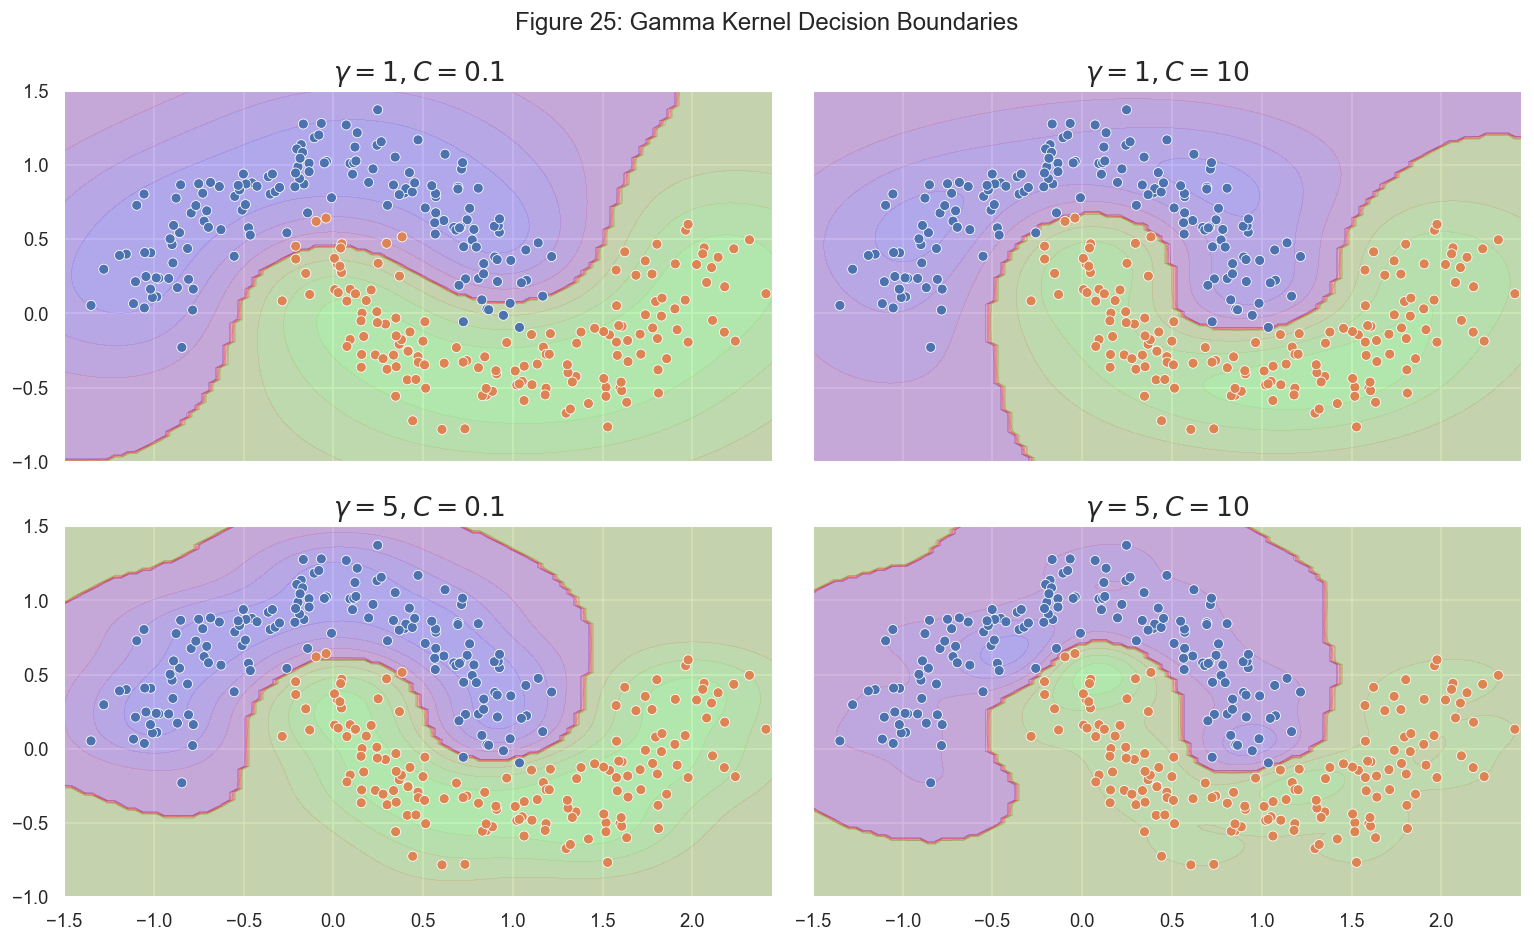

In [20]:
gamma1, gamma2 = 1, 5
C1, C2 = 0.1, 10
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(nl2, y2)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(width_inch*2, height_inch*2), sharex=True, sharey=True)


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i, svm_clf in enumerate(svm_clfs):
        plt.sca(axes[i // 2, i % 2])
        plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
        sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)
        gamma, C = hyperparams[i]
        plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
        if i in (0, 1):
            plt.xlabel("")
        if i in (1, 3):
            plt.ylabel("")

fig_num+=1
plt.suptitle("Figure %d: Gamma Kernel Decision Boundaries"%fig_num)
plt.tight_layout()

if PDF:
    plt.show()
    plt.close()
else:
    plt.close()
    display(MatplotlibFigure(fig, centered=True))

In [21]:
rbf_param_grid = {'svm_clf__C':C_list,
                  'svm_clf__gamma':gamma_list
                 }

rbf = SVC(random_state=42, gamma="auto")
rbf_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", rbf)])

nl2_rbf_gs = hyper_search(rbf_svm, rbf_param_grid, nl2, y2,
                            os.path.join(os.getcwd(), "Models", "moons_rbf_gs.pkl"),
                            overwrite=False
                           )

pd.DataFrame(nl2_rbf_gs.cv_results_).sort_values("rank_test_score")[["param_svm_clf__C", 
                                                                 "param_svm_clf__gamma", 
                                                                 "mean_test_score", 
                                                                 "std_test_score"]].head()

param_svm_clf__C param_svm_clf__gamma  mean_test_score  std_test_score
58                32                    2         0.996667        0.006667
78               512                    2         0.993333        0.008165
107            32768                  0.5         0.993333        0.008165
87              2048                  0.5         0.993333        0.008165
88              2048                    2         0.993333        0.008165

$C$ and $\gamma$ are tightly coupled. 

Generally if you have a larger/narrow `gamma` (e.g. $\gamma = 5$) you'll need more regularisation, so a larger $C$. 

If you have a smaller/wider `gamma` (e.g. $\gamma = 1$), a smaller value of $C$ should be used<sup>7</sup>.

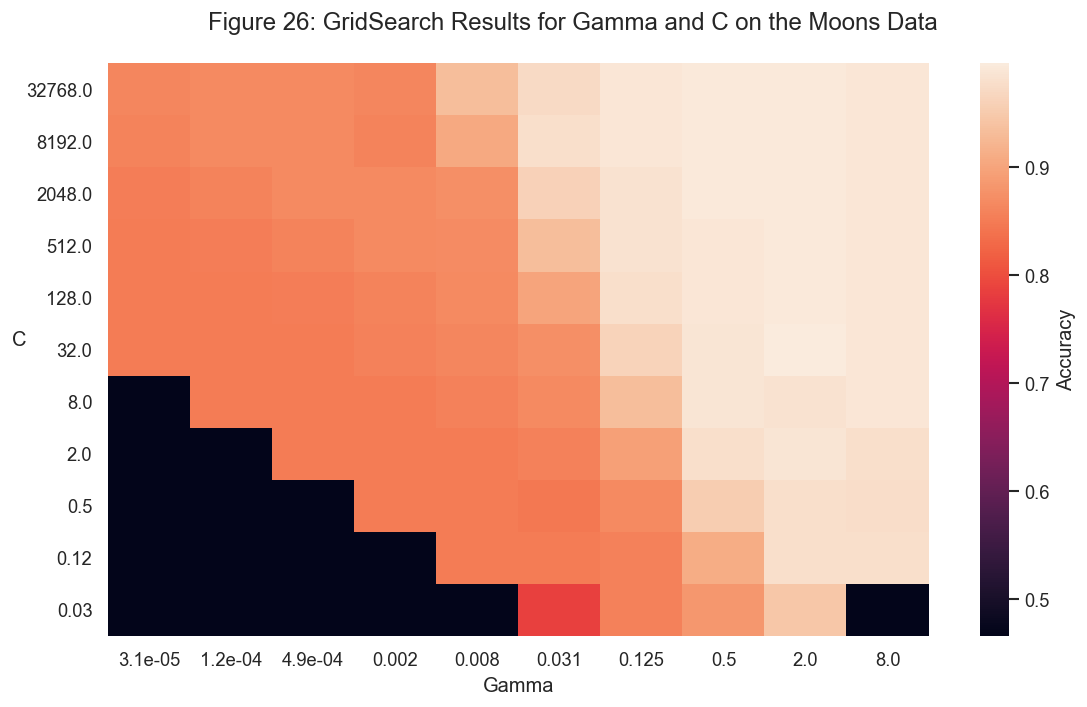

In [22]:
grid_df = pd.DataFrame(nl2_rbf_gs.cv_results_)[["param_svm_clf__C", 
                                                  "param_svm_clf__gamma", 
                                                  "mean_test_score"]]
grid_df = grid_df.sort_values(["param_svm_clf__C", "param_svm_clf__gamma"])
grid_np = np.array(grid_df["mean_test_score"]).reshape(len(C_list), len(gamma_list))

tidied_gamma_lst = list(pd.Series(gamma_list).apply(np.format_float_scientific, precision=1)[0:3].values)
tidied_gamma_lst = tidied_gamma_lst+list(np.array(gamma_list[3:]).round(3))

grid_plt_df = pd.DataFrame(grid_np, 
                           index = np.array(C_list).round(2), 
                           columns=tidied_gamma_lst)


fig = plt.figure(figsize = (width_inch*1.5, height_inch*1.5))
ax = sns.heatmap(grid_plt_df, 
                 vmin=min(grid_df["mean_test_score"]), 
                 vmax=max(grid_df["mean_test_score"]),
                 #cmap="YlGnBu_r"
                )
ax.collections[0].colorbar.set_label("Accuracy")
ax.invert_yaxis()
ax.set_xlabel("Gamma")
ax.set_ylabel("C",rotation = 0)
plt.yticks(rotation = 0)
plt.xticks(rotation = 0)
fig_num+=1
plt.suptitle("Figure %d: GridSearch Results for Gamma and C on the Moons Data"%fig_num)
plt.tight_layout()

if PDF:
    plt.show()
    plt.close()
else:
    plt.close()
    display(MatplotlibFigure(fig, centered=True))

__Extra Example__

Lets have a look at the decision boundaries for our "optimal hyperparameters" as a comparison to those by the linear models we saw earlier.

In [23]:
nl1_poly_gs = hyper_search(poly_svm, poly_param_grid, nl1, y1,
                             os.path.join(os.getcwd(), "Models", "nl1_poly_gs.pkl"), 
                             overwrite=False)

pd.DataFrame(nl1_poly_gs.cv_results_).sort_values("rank_test_score")[["param_svm_clf__C", 
                                                                        "param_svm_clf__gamma",
                                                                        "param_svm_clf__degree",
                                                                        "param_svm_clf__coef0",
                                                                        "mean_test_score", 
                                                                        "std_test_score"]].head()

param_svm_clf__C param_svm_clf__gamma param_svm_clf__degree  \
387             0.125                  0.5                     3   
514             0.125             0.007812                     4   
1545               32              0.03125                     3   
906                 2                0.125                     3   
506             0.125                0.125                     3   

     param_svm_clf__coef0  mean_test_score  std_test_score  
387                     8         0.983333        0.014907  
514                    64         0.983333        0.014907  
1545                   16         0.983333        0.014907  
906                     4         0.983333        0.014907  
506                    64         0.983333        0.014907

In [24]:
nl1_rbf_gs = hyper_search(rbf_svm, rbf_param_grid, nl1, y1,
                            os.path.join(os.getcwd(), "Models", "nl1_rbf_gs.pkl"),
                            overwrite=False
                           )

pd.DataFrame(nl1_rbf_gs.cv_results_).sort_values("rank_test_score")[["param_svm_clf__C", 
                                                                 "param_svm_clf__gamma", 
                                                                 "mean_test_score", 
                                                                 "std_test_score"]].head()

param_svm_clf__C param_svm_clf__gamma  mean_test_score  std_test_score
29              0.5                    8         0.983333        0.014907
27              0.5                  0.5         0.983333        0.014907
28              0.5                    2         0.983333        0.014907
37                2                  0.5         0.983333        0.014907
18            0.125                    2         0.983333        0.014907

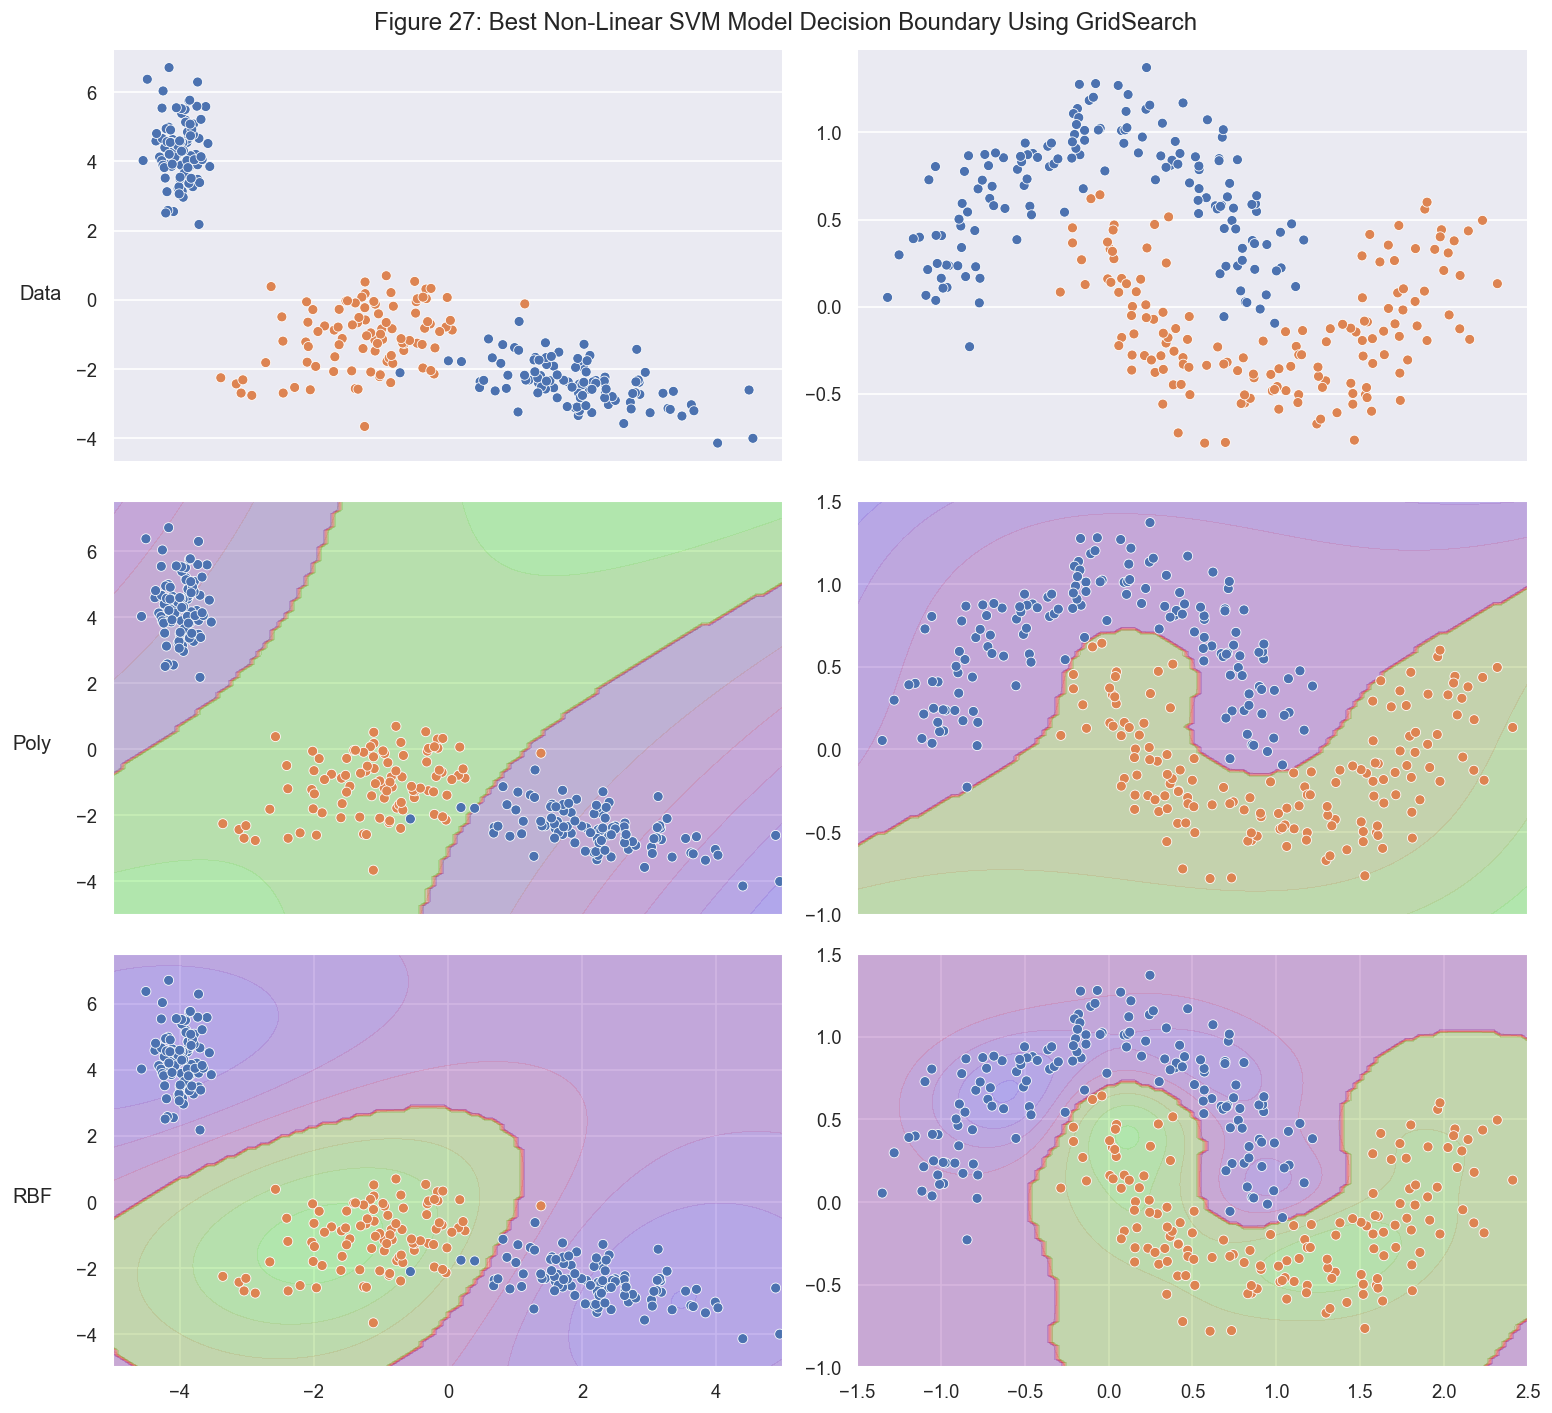

In [25]:
 with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(width_inch*2, height_inch*3))
    
    axes = axes.flatten()
    plt.sca(axes[0])
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)

    plt.sca(axes[1])
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)

    plt.sca(axes[2])
    plot_predictions(nl1_poly_gs, [-5, 5, -5, 7.5])
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)

    plt.sca(axes[3])
    plot_predictions(nl2_poly_gs, [-1.5, 2.5, -1, 1.5])
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)

    plt.sca(axes[4])
    plot_predictions(nl1_rbf_gs, [-5, 5, -5, 7.5])
    sns.scatterplot(nl1[:,0], nl1[:,1], y1, legend=False)

    plt.sca(axes[5])
    plot_predictions(nl2_rbf_gs, [-1.5, 2.5, -1, 1.5])
    sns.scatterplot(nl2[:,0], nl2[:,1], y2, legend=False)
    
    for i in range(4):
        axes[i].axes.xaxis.set_visible(False)

    axes[0].text(-6.5, 0, 'Data')
    axes[2].text(-6.5, 0, 'Poly')
    axes[4].text(-6.5, 0, 'RBF')
    
    fig_num+=1
    plt.suptitle("Figure %d: Best Non-Linear SVM Model Decision Boundary Using GridSearch"%fig_num)
    plt.tight_layout()
    
    if PDF:
        plt.show()
        plt.close()
    else:
        plt.close()
        display(MatplotlibFigure(fig, centered=True))

### Standardization$^{11}$

SVMs, along with many other machine learning estimators (e.g. l1 and l2 regularizers of linear models), are sensitive to feature scales. 

If a feature has a variance orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected.

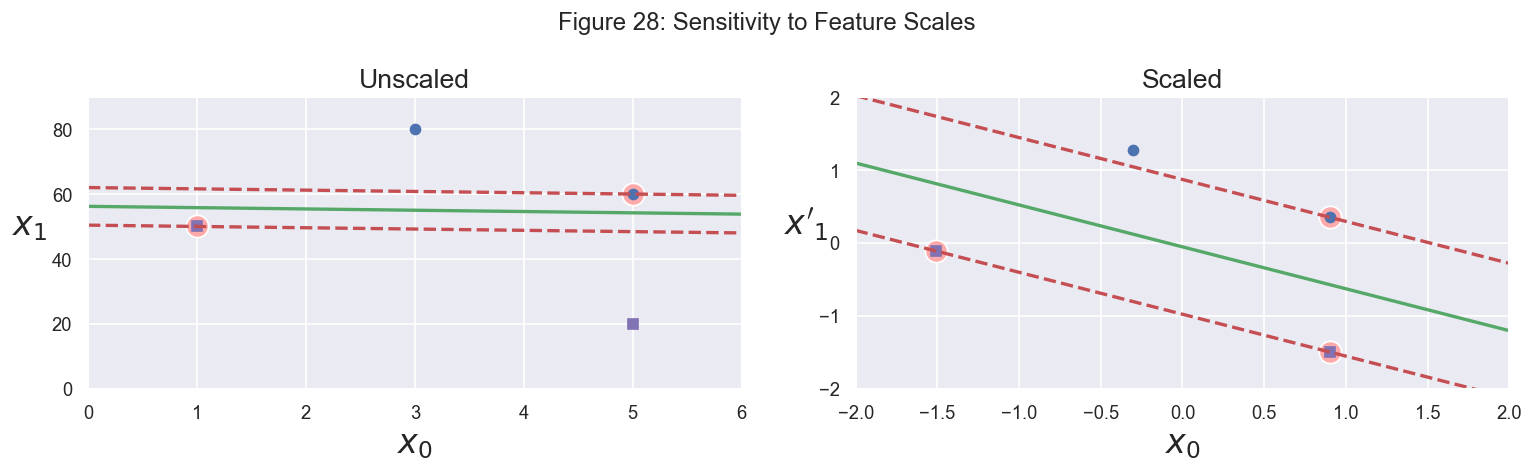

In [26]:
# copied from https://github.com/ageron/handson-ml2/blob/master/05_support_vector_machines.ipynb
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

fig = plt.figure(figsize=(width_inch*2, height_inch))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

fig_num+=1
plt.suptitle("Figure %d: Sensitivity to Feature Scales"%fig_num)
plt.tight_layout()
if PDF:
    plt.show()
    plt.close()
else:
    plt.close()
    display(MatplotlibFigure(fig, centered=True))

__Notes__

- We can see that in the unscaled plot that $\mathbf{x}_1$ is much larger than $\mathbf{x}_0$ so the widest street is very close to the horizontal.
- After scaling we have a much better decision boundary.

Standardization is especially important for RBF kernels. 

These models assume that all features look like standard normally distributed data: Gaussian with zero mean and unit variance.

#### Dataset Example: Breast Cancer

We can see below for example that the features in the Breast Cancer dataset are of completely different orders of magnitude$^{16}$.

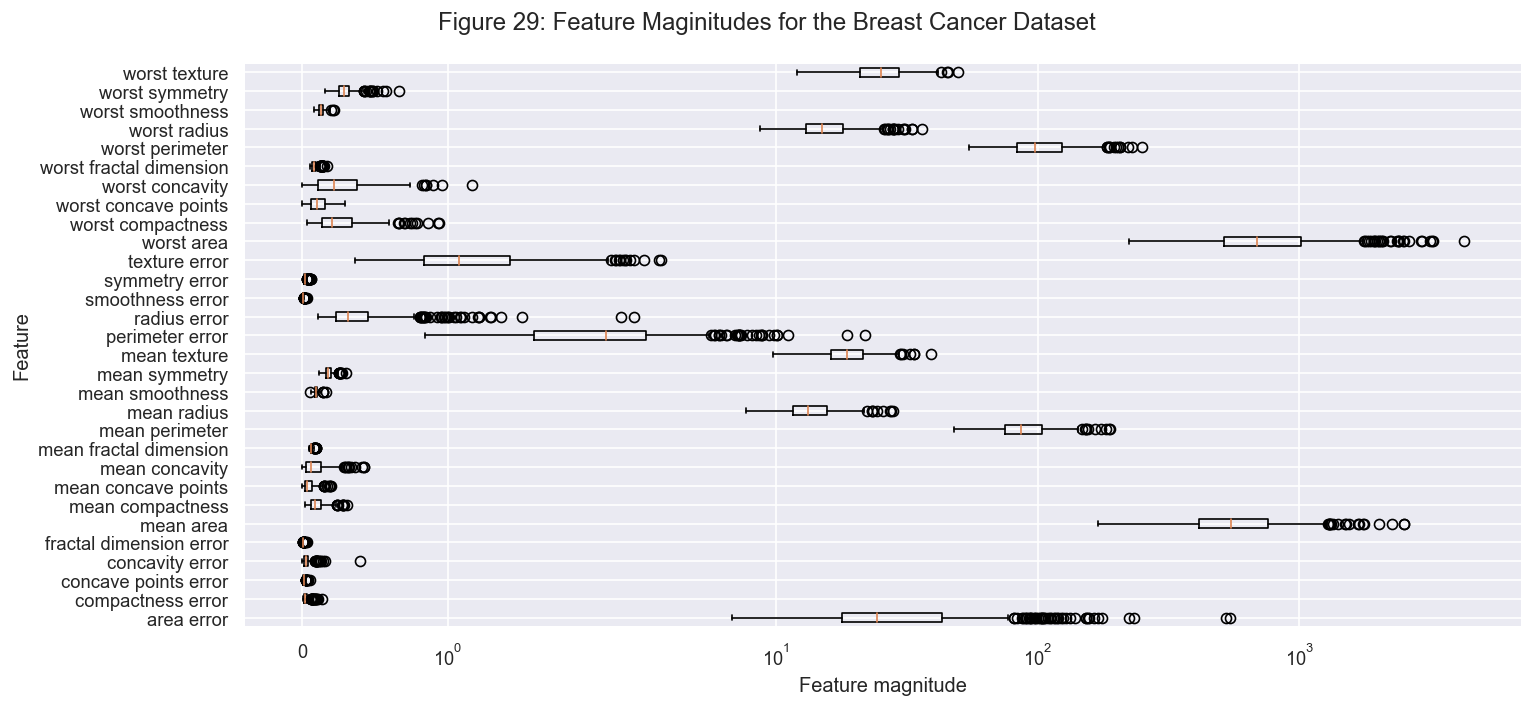

In [27]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X = X.reindex(sorted(X.columns), axis=1)

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values,
                                                    test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size = 0.2, random_state=42)

fig, ax = plt.subplots(figsize=(width_inch*2, height_inch*1.5))

plt.boxplot(X_train, vert=False) 
plt.xscale("symlog") 
plt.ylabel("Feature") 
plt.xlabel("Feature magnitude")

ax.set_yticklabels(list(X.columns))

fig_num+=1
plt.suptitle("Figure %d: Feature Maginitudes for the Breast Cancer Dataset"%fig_num)
plt.tight_layout()
if PDF:
    plt.show()
    plt.close()
else:
    plt.close()
    display(MatplotlibFigure(fig, centered=True))

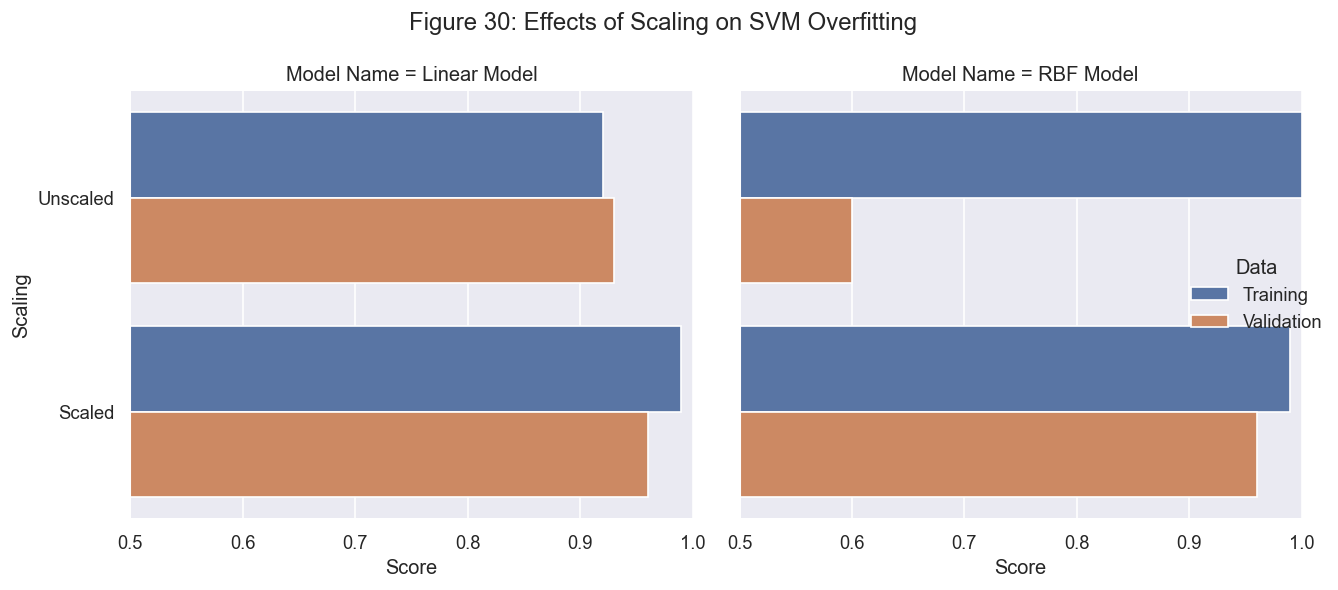

In [28]:
from sklearn.metrics import accuracy_score

lin = LinearSVC(random_state=42)
rbf = SVC(random_state=42, gamma="auto")

linear_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", lin)
    ])

rbf_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", rbf)])

model_name = ["Linear Model", "Linear Model", "RBF Model", "RBF Model"]

for i, model in enumerate([lin, linear_svm, rbf, rbf_svm]):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        trained_model = model.fit(X_train, y_train)
        pred_train = trained_model.predict(X_train)
        pred_val = trained_model.predict(X_val)
        
        if (i % 2) == 0:
            scaled = "Unscaled"
        else:
            scaled = "Scaled"
        
        score_df = pd.DataFrame([round(accuracy_score(y_train, pred_train),2), 
                                 round(accuracy_score(y_val, pred_val),2)], columns = ["Score"])
        
        score_df["Data"] = ['Training', 'Validation']
        score_df["Model Name"] = model_name[i]
        score_df["Scaling"] = scaled
        
        if i == 0:
            scores_df = score_df
        else:
            scores_df = pd.concat([scores_df, score_df], axis=0)

#fig = plt.figure(figsize=(width_inch, height_inch))
#fig, ax = plt.subplots(figsize=(width_inch, height_inch))
sns_plot = sns.catplot(data = scores_df, y="Scaling", x = "Score", hue="Data", kind="bar", col="Model Name", ax=ax)
fig = sns_plot.fig
plt.xlim(0.5,1.0)
fig_num+=1
plt.suptitle("Figure %d: Effects of Scaling on SVM Overfitting"%fig_num)
plt.tight_layout()
if PDF:
    plt.show()
    plt.close()
else:
    plt.close()
    display(MatplotlibFigure(fig, centered=True))

__Notes__

- In this example, the RBF model overfits quite substantially, with a perfect score on the training set and only 60% accuracy on the test set. 
- Also you see the linear model also has a minor improvement in accuracy if scaled.

## Recap$^1$

The kernel approach is an efficient computational approach to enlarge our feature space to accommodate a non-linear boundary.

Assume we have a new point $x^*$. If wanted to compute $f(x^*)$ using our linear classifier we would need to the inner product between $x^*$ and each training point $x_i$:

$$f(x) = \sum_{i\in s}\alpha_i \left<x^*,x_i\right> + b.$$

Instead of actually calculating the inner product, we could instead use a _generalisation_, $K(x,x_{i^{\prime}})$, where $K$ is a _kernel_. We can now define the classifier as:

$$f(x) = \sum_{i\in s}\alpha_i K\left(x^*,x_i\right) + b.$$

A kernel is a function that quantifies the similarity of two observations. For example, for a _linear kernel_ we could use:

$$K(x_i, x_{i^\prime}) = \sum^p_{j=1}x_{ij}x_{{i^\prime}j},$$

where we quantifiy the similarity of pairs of observations using Pearson (standard) correlation.

However, we could use other forms of kernel to fit the support vector classifier in a higher-dimensional space, such as a _polynomial kernel_:

$$K(x_i, x_{i^\prime}) = \left(\gamma \sum^p_{j=1}x_{ij}x_{{i^\prime}j} + r\right)^d.$$

Another popular choice is the _radial kernel_:

$$K(x_i, x_{i^\prime}) = \exp\left(-\gamma\sum^p_{j=1}(x_{ij}-x_{{i^\prime}j})^2\right).$$

# Associated Exercises

Now might be a good time to try exercises 5-8.

# References
1. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2013). An introduction to statistical learning (Vol. 112, p. 18). New York: springer.
2. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
3. Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. " O'Reilly Media, Inc.".
4. Raschka, 2016
5. Cortes, C. and Vapnik, V. Support vector networks. Machine Learning, 20:273–297, 1995
6. Burges, C. J. (1998). A tutorial on support vector machines for pattern recognition. Data mining and knowledge discovery, 2(2), 121-167.
7. Murphy, K. P. (2012). Machine learning: a probabilistic perspective. MIT press.
8. Burkov, A. (2019). The hundred-page machine learning book (Vol. 1). Canada: Andriy Burkov.
9. Zhang, J. (2015). A complete list of kernels used in support vector machines. Biochem. Pharmacol.(Los Angel), 4, 2167-0501.
10. Raschka, Sebastian, and Vahid Mirjalili. "Python Machine Learning: Machine Learning and Deep Learning with Python." Scikit-Learn, and TensorFlow. Second edition ed (2017).
11. https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
12. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
13. Al-Mejibli, I. S., Alwan, J. K., & Abd Dhafar, H. (2020). The effect of gamma value on support vector machine performance with different kernels. International Journal of Electrical and Computer Engineering, 10(5), 5497.

In [29]:
import sys
from shutil import copyfile

# where the HTML template is located
dst = os.path.join(sys.prefix, 'lib', 'site-packages', 'nbconvert', 'templates', "classic.tplx")

# If its not located where it should be
if not os.path.exists(dst):
    # uses a nb_pdf_template
    curr_path = os.path.join(os.getcwd(),"..", "Extra", "classic.tplx")
    # copy where it is meant to be
    copyfile(curr_path, dst)

if not PDF:
    # Create HTML notes document (preferred)
    !jupyter nbconvert 2_Support_Vector_Machines.ipynb \
        --to html \
        --output-dir . \
        --template classic
    !jupyter nbconvert 2_Support_Vector_Machines.ipynb \
        --to slides \
        --output-dir . \
        --TemplateExporter.exclude_input=True \
        --TemplateExporter.exclude_output_prompt=True \
        --SlidesExporter.reveal_scroll=True
else:
    # Create pdf notes document (issues)
    !jupyter nbconvert 2_Support_Vector_Machines.ipynb \
        --to pdf \
        --output-dir . \
        --TemplateExporter.exclude_input=True \
        --TemplateExporter.exclude_output_prompt=True

[NbConvertApp] Converting notebook 2_Support_Vector_Machines.ipynb to pdf
[NbConvertApp] Support files will be in 2_Support_Vector_Machines_files\
[NbConvertApp] Making directory .\2_Support_Vector_Machines_files
[NbConvertApp] Making directory .\2_Support_Vector_Machines_files
[NbConvertApp] Making directory .\2_Support_Vector_Machines_files
[NbConvertApp] Making directory .\2_Support_Vector_Machines_files
[NbConvertApp] Making directory .\2_Support_Vector_Machines_files
[NbConvertApp] Making directory .\2_Support_Vector_Machines_files
[NbConvertApp] Making directory .\2_Support_Vector_Machines_files
[NbConvertApp] Making directory .\2_Support_Vector_Machines_files
[NbConvertApp] Making directory .\2_Support_Vector_Machines_files
[NbConvertApp] Making directory .\2_Support_Vector_Machines_files
[NbConvertApp] Making directory .\2_Support_Vector_Machines_files
[NbConvertApp] Making directory .\2_Support_Vector_Machines_files
[NbConvertApp] Making directory .\2_Support_Vector_Machines_f